In [ ]:
!pip install roboflow

In [161]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import keras
from tensorflow.keras import layers
from roboflow import Roboflow
import random
import os
from keras.optimizers import SGD
from keras.utils import np_utils


In [29]:
rf = Roboflow(api_key="VdwBRxsJsFmCMW94xJjd")
project = rf.workspace("object-detection-yolov5").project("plate_ocr_ir")
dataset = project.version(2).download("folder")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to plate_ocr_ir-2 in folder:: 100%|██████████| 9658/9658 [00:02<00:00, 4655.90it/s]


In [162]:
train_path = '/content/plate_ocr_ir-2/train'
valid_path = '/content/plate_ocr_ir-2/valid'
test_path = '/content/plate_ocr_ir-2/test'

In [163]:
class_names = subdirs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'ch', 'd', 'ein', 'f', 'g', 'ghaf', 'ghein', 'h2', 'hj', 'j', 'k', 'kh', 'l', 'm', 'n', 'p', 'r', 's', 'sad', 'sh', 't', 'ta', 'th', 'v', 'y', 'z', 'za', 'zad', 'zal', 'zh']
num_classes = len(class_names)

In [164]:
labels_nums = [i for i in range(0,len(class_names))]
print(labels_nums)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


In [165]:
train_imgs = []
train_labels = []
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(train_path, subdir)
  for imgname in os.listdir(imgfolder):
    img = cv.imread(os.path.join(imgfolder, imgname), 0)
    train_imgs.append(img)
    train_labels.append(labels_nums[indx])

c = list(zip(train_imgs, train_labels))
random.shuffle(c)
train_imgs, train_labels = zip(*c)

train_images = np.array(train_imgs)
train_labels = np.array(train_labels)

In [166]:
valid_imgs = []
valid_labels = []
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(valid_path, subdir)
  if os.path.exists(imgfolder):
    for imgname in os.listdir(imgfolder):
      img = cv.imread(os.path.join(imgfolder, imgname), 0)
      valid_imgs.append(img)
      valid_labels.append(labels_nums[indx])

c = list(zip(valid_imgs, valid_labels))
random.shuffle(c)
valid_imgs, valid_labels = zip(*c)

test_images = np.array(valid_imgs)
test_labels = np.array(valid_labels)

In [182]:
x_train = np.array(train_images, dtype = 'float') / 255.0
x_test = np.array(test_images, dtype = 'float') / 255.0

In [183]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [184]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [185]:
x_train_r = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_r = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [186]:
print(x_train_r.shape)
print(x_test_r.shape)

(8337, 28, 28, 1)
(792, 28, 28, 1)


In [187]:
print(y_train.shape)
print(y_test.shape)

(8337, 42)
(792, 42)


In [188]:
def build_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(32, (3,3), input_shape = (28, 28, 1), padding = 'same', activation = 'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))

  model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))

  model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(1024, activation = 'relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(512, activation = 'relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(42, activation = 'softmax'))

  model.summary()

  return model

In [189]:
model = build_model()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 dropout_45 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_46 (Dropout)        (None, 14, 14, 64)        0         
                                                     

In [190]:
epochs = 50
learning_rate = 0.01
deacy_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr = learning_rate, momentum=momentum, decay = deacy_rate)

The `lr` argument is deprecated, use `learning_rate` instead.


In [191]:
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [192]:
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [193]:
model_h = model.fit(x_train_r, y_train, batch_size = 32, epochs = epochs,
                    validation_data = (x_test_r, y_test), callbacks = [callback])

Epoch 1/50
261/261 [==============================] - 3s 7ms/step - loss: 3.7217 - accuracy: 0.0270 - val_loss: 3.7132 - val_accuracy: 0.0265
Epoch 2/50
261/261 [==============================] - 2s 6ms/step - loss: 3.5557 - accuracy: 0.0607 - val_loss: 2.7890 - val_accuracy: 0.2374
Epoch 3/50
261/261 [==============================] - 2s 6ms/step - loss: 2.1881 - accuracy: 0.3432 - val_loss: 1.1222 - val_accuracy: 0.5795
Epoch 4/50
261/261 [==============================] - 2s 6ms/step - loss: 1.1905 - accuracy: 0.6136 - val_loss: 0.6114 - val_accuracy: 0.8056
Epoch 5/50
261/261 [==============================] - 2s 6ms/step - loss: 0.7772 - accuracy: 0.7370 - val_loss: 0.5274 - val_accuracy: 0.8194
Epoch 6/50
261/261 [==============================] - 2s 8ms/step - loss: 0.5576 - accuracy: 0.8089 - val_loss: 0.3432 - val_accuracy: 0.8826
Epoch 7/50
261/261 [==============================] - 2s 7ms/step - loss: 0.4482 - accuracy: 0.8417 - val_loss: 0.2673 - val_accuracy: 0.9141
Epoch 

In [233]:
val_imgs = []
val_labels = []
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(test_path, subdir)
  for imgname in os.listdir(imgfolder):
    img = cv.imread(os.path.join(imgfolder, imgname), 0)
    val_imgs.append(img)
    val_labels.append(labels_nums[indx])

c = list(zip(val_imgs, val_labels))
random.shuffle(c)
val_imgs, val_labels = zip(*c)

val_imgs = np.array(val_imgs)
val_labels = np.array(val_labels)

In [234]:
print(val_labels.shape)

(398,)


In [235]:
x_val = np.array(val_imgs, dtype = 'float') / 255.0

In [236]:
y_val = np.array(val_labels)

In [237]:
y_val = np_utils.to_categorical(y_val)

In [238]:
print(y_val.shape)

(398, 42)


In [239]:
x_val_r = x_val.reshape(x_val.shape[0], 28, 28, 1)

In [240]:
prediction = model.predict(x_val_r)

13/13 [==============================] - 0s 21ms/step


In [241]:
y_val.shape

(398, 42)

In [242]:
model.save('Car-L.h5')

13/13 [==============================] - 0s 2ms/step


Text(95.72222222222221, 0.5, 'Truth')

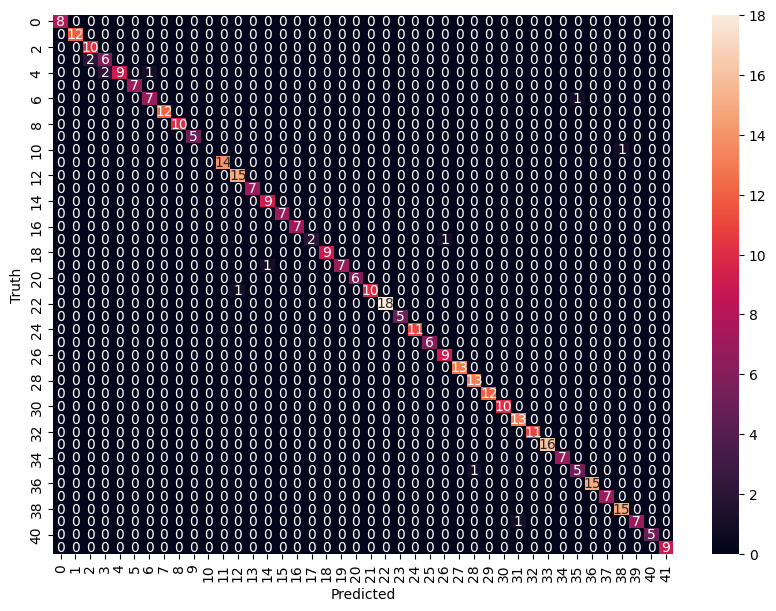

In [243]:
y_predicted = model.predict(x_val_r)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_test_categorical = tf.argmax(y_val, axis=1)

cm = tf.math.confusion_matrix(labels=y_test_categorical, predictions=y_predicted_labels)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')